In [2]:
#Import Statements
import numpy as np 
from matplotlib import pyplot as plt 
import os, sys
from datetime import datetime
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import models
from torchsummary import summary
from scipy.stats import t
import math
from prediction_classes import fx_data_set,NeuralNetwork

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        y=y[:,None]
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_t=-1
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            loss_t=loss
        return loss_t
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
        
def form_prediction(open_data,close_data,high_data,low_data,td_days):
    #prepare data

    #create inputs and outputs matrices
    num_prec=5
    input_data=np.zeros((int(4*num_prec),1,len(open_data)-num_prec-1)) #exclude the final point cuz that will be used for pred
    output_data=np.zeros((1,1,len(open_data)-num_prec-1))
    min_arr=np.zeros(len(open_data)-num_prec-1)
    max_arr=np.zeros(len(open_data)-num_prec-1)
    for i in range(num_prec,len(open_data)-1):
        td=td_days[i-num_prec:i]-td_days[i] #number of days before present
        td=1/td
        td=td/(max(td))
        td=1
        opens=(open_data[i-num_prec:i]*td)
        closes=(close_data[i-num_prec:i]*td)
        highs=(high_data[i-num_prec:i]*td)
        lows=(low_data[i-num_prec:i]*td)
        input_data[0:num_prec,0,i-num_prec]=opens
        input_data[num_prec:int(2*num_prec),0,i-num_prec]=closes
        input_data[int(2*num_prec):int(3*num_prec),0,i-num_prec]=highs
        input_data[int(3*num_prec):int(4*num_prec),0,i-num_prec]=lows
        min_arr[i-num_prec]=min(input_data[:,0,i-num_prec])
        max_arr[i-num_prec]=max(input_data[:,0,i-num_prec])
        output_data[0,0,i-num_prec]=close_data[i]

    input_data=(input_data-min(min_arr))/(max(max_arr)-min(min_arr)) #data standardization
    output_data=(output_data-min(min_arr))/(max(max_arr)-min(min_arr))
    
    #Apply custom dataset class to formatted data mat

    fx_dataset=fx_data_set(input_data,output_data)
    fx_dataload=DataLoader(fx_dataset,batch_size=16)
    
    # Get cpu or gpu device for training.
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    #main loop
    model_num=10
    model_err=np.zeros(model_num)
    model_perc=np.zeros(model_num)
    main_perc_correct=0
    main_model=[]
    main_err=1000
    for k in range(0,model_num):
        model = NeuralNetwork().to(device)
        loss_fn = nn.MSELoss()
        optimizer=torch.optim.AdamW(model.parameters())
        epochs = 500
        loss=[]
        for t in range(epochs):
            new_loss=train(fx_dataload, model, loss_fn, optimizer)
            if new_loss!=-1:
                loss.append(new_loss)
        model_stats = summary(model)
        summary_str = str(model_stats)
        model.eval()
        model.cpu()
        device="cpu"
        pred_arr=np.zeros(fx_dataset.__len__())
        y_arr=np.zeros(fx_dataset.__len__())
        for i in range(0,fx_dataset.__len__()):
            x,y = fx_dataset.__getitem__(i)
            pred=model(x)
            pred_np=pred.cpu().detach().numpy() 
            pred_arr[i]=pred_np
            y_np=y.cpu().detach().numpy() 
            y_arr[i]=y_np
        pred_delt=pred_arr-(close_data[num_prec-1:len(close_data)-2]-min(min_arr))/(max(max_arr)-min(min_arr)) 
        act_delt=y_arr-(close_data[num_prec-1:len(close_data)-2]-min(min_arr))/(max(max_arr)-min(min_arr))
        perc_correct=0
        for i in range(0,len(pred_delt)):
            if pred_delt[i]*act_delt[i]>0:
                perc_correct+=100*(1/len(pred_delt))
        model_err[k]=new_loss
        model_perc[k]=perc_correct
        if perc_correct*(1.5-1/(1+np.exp(-1*new_loss)))>main_perc_correct*(1.5-1/(1+np.exp(-1*main_err))):
            main_model=model
            main_err=new_loss
            main_perc_correct=perc_correct
    
    model=main_model
    std_dev=np.std(model_perc)
    mean=np.mean(model_perc)
    dof=model_num-1
    t_val=(50-mean)/(std_dev/math.sqrt(model_num))
    p_val=2*(1 - t.cdf(abs(t_val), dof))
    if mean<50:
        p_val=1-p_val
        
    #Determine trade size

    max_trade=100
    trade_size=max_trade*(1.5-(1/(1+np.exp(-1*main_err))))*(1-p_val)*(perc_correct/100)
    
    return trade_size

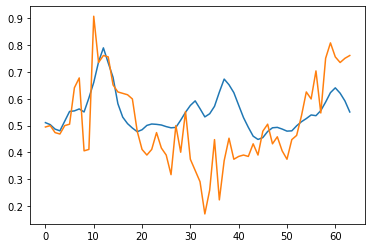

In [18]:
model.eval()
model.cpu()
device="cpu"
pred_arr=np.zeros(fx_dataset.__len__())
y_arr=np.zeros(fx_dataset.__len__())
for i in range(0,fx_dataset.__len__()):
    x,y = fx_dataset.__getitem__(i)
    pred=model(x)
    pred_np=pred.cpu().detach().numpy() 
    pred_arr[i]=pred_np
    y_np=y.cpu().detach().numpy() 
    y_arr[i]=y_np
plt.plot(pred_arr)
plt.plot(y_arr)

60.9375


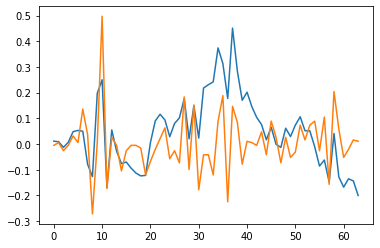

In [19]:
#delta interp
pred_delt=pred_arr-(close_data[num_prec-1:len(close_data)-2]-min(min_arr))/(max(max_arr)-min(min_arr)) 
act_delt=y_arr-(close_data[num_prec-1:len(close_data)-2]-min(min_arr))/(max(max_arr)-min(min_arr))
plt.plot(pred_delt)
plt.plot(act_delt)
perc_correct=0
for i in range(0,len(pred_delt)):
    if pred_delt[i]*act_delt[i]>0:
        perc_correct+=100*(1/len(pred_delt))

In [26]:
#Determine trade size

max_trade=100
trade_size=max_trade*(1.5-(1/(1+np.exp(-1*main_err))))*(1-p_val)*(perc_correct/100)
print(trade_size)
print((1/(1+np.exp(-1*main_err))))
print(main_err)

60.768775963275864
0.5023052557009607
0.009221088141202927


In [15]:

#try altering num_prec
#original: 5
#try 8
#make program flexible enough to accept variable num_prec

#try designing custom loss function that penalizes more heavily for incorrect signs 

#try reintroducing td:
    #first test gave 59% 
    
#consider using batch normalization and reintroducing td 
    #should elim problems with td 

#add try except to web scrape

#add actual prediction value 

#remove all print statements